## **Advances in Data Mining**

Stephan van der Putten | (s1528459) | stvdputtenjur@gmail.com  
Theo Baart | s2370328 | s2370328@student.leidenuniv.nl

### **Assignment 3**
This assignment is concerned with performing an analysis of and execute PageRank on the wikipedia links given in the `wikilink_graph.2004-03-01.csv` file. In order to do this the assignment is split up into four subtasks with each subtask receiving its dedicated `.ipynb` file. See each specific file for details on what this notebook accomplishes.

Note all implementations are based on the assignment guidelines and helper files given as well as the documentation of the used functions. 

#### **Exploratory Data Analysis**
This notebook performs an exploratory analysis on the dataset. This includes some anlaysis on the nodes and edges as well as estimating system requirements for being able to execute the PageRank algorithm.
___

### **Helper Functions**
This section contains functions which aid and simplify the code.
___
The following snippet handles all imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.sparse
from scipy.sparse import csr_matrix

The `load_prepped_data` function is responsible for retrieving the data prepped by `prep.ipynb` and loading it for exploratory data analysis.

In order to do this the function uses the following parameters:
  * `filename` - the name of the file containing the prepped data [default = `prep-data.npz`]
  
Additionally, it returns the following value:
  * `data` - an array representing the prepped data  

In [2]:
def load_prepped_data(filename = 'prep_data.npz'):
    data = scipy.sparse.load_npz(filename)
    return data

The following snippet triggers data loading

In [3]:
data = load_prepped_data()

The `plot_distribution` function plots the distribution of a one-dimensional sparse matrix.

In order to do this the function uses the following parameters:
  * `data` - the one-dimensional sparse matrix to be plotted
  * `title` - the title to give the plot [default = `'distribution'`]
  * `ignore_zeros` - whether to include zeros in the distrubtion [default = `True`]

In [4]:
def plot_distribution(data,title='distribution',ignore_zeros=True):
    data = data.toarray()[0]
    if ignore_zeros:
        data = data[data!=0]
#     print(data)
    data = np.log(data)
#     print(data.min(),data.max())
    sns.set_style("white")
    plot = sns.distplot(data,norm_hist=False)
    plot.set(xlim={data.min()-0.5,data.max()+0.5})
    plot.set(xlabel="log of degree counts",ylabel='something',title=title)
    sns.despine()
    plt.show()

The `compute_average` function computes the average value of a one-dimensional sparse matrix.

In order to do this the function uses the following parameters:
  * `data` - the one-dimensional sparse matrix we want the average of
  * `ignore_zero` - whether to ignore zeros [default = `True`]

Additionally, it returns the following value:
  * `average` - the average value of the given matrix.

In [5]:
def compute_average(data,ignore_zero=True):
    if ignore_zero:
        # built in functions don't ignore zeros
        d_sum = data.sum()
        d_len = data.count_nonzero()
        average = d_sum / d_len
    else:
        average = data.mean()
    return average

The `compute_x_degrees` function parses the nodes and computes for each node the x-degree of the node.

In order to do this the function uses the following parameters:
  * `data` - the prepped data
  * `x` - whether to compute the in- or out-degree [default = `in`]
  
Additionally, it returns the following value:
  * `x_degrees` - a list of all the nodes and their x-degrees

In [6]:
def compute_x_degrees(data, x = 'in'):
    if x == 'in':
        edges = data.nonzero()[0]
        edges_length = data.get_shape()[0]
    else:
        edges = data.nonzero()[1]
        edges_length = data.get_shape()[1]
    edges_index, edges_count = np.unique(edges, return_counts=True)
    edges_nonzero_length = len(edges_index)
    edges_zeros = np.zeros(edges_nonzero_length)
#     print(edges_count)
#     print(np.log(edges_count))
#     print(edges_index,edges_count,edges_zeros,edges_nonzero_length,edges_length)
    x_degrees = csr_matrix((edges_count, (edges_zeros,edges_index)), shape=(1,edges_length))
#     print(x_degrees)
    return x_degrees

The `compute_average_link_count` function parses the nodes and computes the average number of links per node.

In order to do this the function uses the following parameters:
  * `data` - the prepped data
  
Additionally, it returns the following value:
  * `average` - the average number of links per node

In [7]:
def compute_average_link_count(data):
    num_nodes = data.get_shape()[0]
    num_links = data.getnnz()
    average = num_nodes / num_links
    return average

The `compute_x_bytes` function receives a value and converts it to the closest logical unit. This is defined by being the largest unit such that there is always a value before the decimal point. The largest allowed unit is `GB` and additionally the value is always rounded to 3 decimal places.

In order to do this the function uses the following parameters:
  * `total_bytes` - the value to convert
  * `format_override` - use to manually force a format [supports: `[GB, MB, KB, B, None]`, default = `None`]
  
Additionally, it returns the following value:
  * `converted_bytes` - the converted value rounded to 3 decimal places
  * `unit_bytes` - a textual representation of the unit used

In [8]:
def compute_x_bytes(total_bytes, format_override=None):
    if format_override is not None:
        unit_bytes = format_override
        if format_override == 'B':
            converted_bytes = total_bytes
        elif format_override == 'KB':
            converted_bytes = total_bytes / 1e3
        elif format_override == 'MB':
            converted_bytes = total_bytes / 1e6
        elif format_override == 'GB':
            converted_bytes = total_bytes / 1e9
    else :
        if total_bytes % 1e9 < total_bytes:
            converted_bytes = total_bytes / 1e9
            unit_bytes = 'GB'
        elif total_bytes % 1e6 < total_bytes:
            converted_bytes = total_bytes / 1e6
            unit_bytes = 'MB'
        elif total_bytes % 1e3 < total_bytes:
            converted_bytes = total_bytes / 1e3
            unit_bytes = 'KB'
        else:
            converted_bytes = total_bytes
            unit_bytes = 'B'
    converted_bytes = round(converted_bytes,3)
    return converted_bytes, unit_bytes   

#### **Dead Ends**
This section is concerned with determining how many dead ends there are. A dead end refers to nodes which do not have any outgoing edges.
___
The `compute_dead_ends_set` function parses the nodes and computes a set of all nodes which are dead_ends. Analyzing the data it is evident that for a node to be in the dataset it must either have an outgoing edge or an incoming edge. By definition a dead end has no outgoing edges and therefore it cannot be in the list of outgoing edges. Thus, the difference between the set of all edges and the set of outgoing edges is the set of dead ends.

In order to do this the function uses the following parameters:
  * `data` - the prepped data
  
Additionally, it returns the following value:
  * `dead_ends` - a list of all the dead ends [in consecutive numbering]

In [9]:
def compute_dead_ends_set(data):
    all_edges = set(range(data.get_shape()[1])) # get all column ID's 
    outgoing_edges = set(data.nonzero()[1]) # column ID's of outgoing edges
#     print(all_edges)
#     print(outgoing_edges)
    dead_ends = all_edges - outgoing_edges
#     print(dead_ends)
    dead_ends = set(dead_ends)
    return dead_ends

The `analyse_dead_ends` function analyzes the matrix and prints some data on the dead ends in the graph.

In order to do this the function uses the following parameters:
  * `data` - the prepped data
  * `print_set`  - whether to print the set of dead ends [default = `False`]

In [10]:
def analyze_dead_ends(data,print_set=False):
    dead_ends = compute_dead_ends_set(data)
    count_dead_ends = len(dead_ends)
    if count_dead_ends == 0:
        print("There are no dead ends")
        return
    # TODO convert consecutive numbering to original number
    if count_dead_ends == 1:
        print("There is 1 dead end.")
    else:
        print("There are "+str(len(dead_ends))+" dead ends.")
    if print_set:
        print("The following set contains all nodes classified as dead ends [in consecutive numbering].")
        print(dead_ends)

The following snippet triggers the dead end analysis

In [11]:
%time analyze_dead_ends(data)

There are 56155 dead ends.
CPU times: user 1.44 s, sys: 49.2 ms, total: 1.49 s
Wall time: 418 ms


#### **In-degrees**
This section is concerned with analyzing the in-degrees of the nodes. An in-degree refers to the number of incoming edges that a node has.
___
The `analyze_in_degrees` function analyzes the matrix and prints some data on the in-degrees of the graph. This includes a distribution of the in-degrees as well as the average number of in-degrees.

In order to do this the function uses the following parameters:
  * `data` - the prepped data
  * `ignore_zeros_plot` - whether to plot zeros [default = `True`]

In [12]:
def analyze_in_degrees(data,ignore_zeros_plot = True):
    in_degrees = compute_x_degrees(data, 'in')
    
    # Distribution
    plot_distribution(in_degrees,title='Log distribution of in-degrees',ignore_zeros=ignore_zeros_plot)
    
    # Averages
    average_zero = compute_average(in_degrees,ignore_zero=False)
    average_nonzero = compute_average(in_degrees,ignore_zero=True)
    print("The average in-degree (including zeros): " + str(average_zero))
    print("The average in-degree (excluding zeros): " + str(average_nonzero))

The following snippet triggers the in-degree analysis

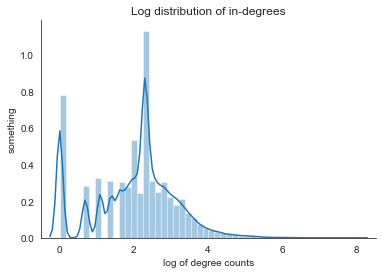

The average in-degree (including zeros): 12.774792197978504
The average in-degree (excluding zeros): 13.736067306692545
CPU times: user 2.16 s, sys: 32.4 ms, total: 2.2 s
Wall time: 515 ms


In [13]:
%time analyze_in_degrees(data)

#### **Out-degrees**
This section is concerned with analyzing the out-degrees of the nodes. An out-degree refers to the number of outgoinng edges that a node has.
___
The `analyze_out_degrees` function analyzes the matrix and prints some data on the out-degrees of the graph. This includes a distribution of the out-degrees as well as the average number of out-degrees.

In order to do this the function uses the following parameters:
  * `data` - the prepped data
  * `ignore_zeros_plot` - whether to plot zeros [default = `True`]

In [14]:
def analyze_out_degrees(data,ignore_zeros_plot = True):
    out_degrees = compute_x_degrees(data,'out')
    
    # Distribution
    plot_distribution(out_degrees,title='Log distribution of out-degrees',ignore_zeros=ignore_zeros_plot)
    
    # Averages
    average_zero = compute_average(out_degrees,ignore_zero=False)
    average_nonzero = compute_average(out_degrees,ignore_zero=True)
    print("The average out-degree (including zeros): " + str(average_zero))
    print("The average out-degree (excluding zeros): " + str(average_nonzero))

The following snippet triggers the out-degree analysis

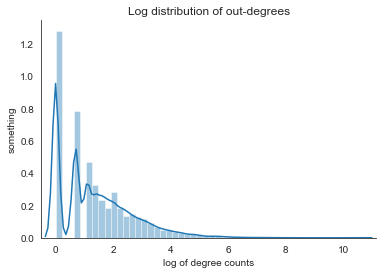

The average out-degree (including zeros): 12.774792197956312
The average out-degree (excluding zeros): 16.510346910507295


In [15]:
analyze_out_degrees(data)

#### **RAM requirements**
This section is concerned with analyzing the RAM requirements for various implementations of the transition matrix and the initial vector. 

Note that double precision is assumed (e.g. 64 bits per value).
___
The `compute_ram_traditional` function analyzes the ram requirements using the traditional implementation of the transition matrix and the initial vector.

In order to do this the function uses the following parameters:
  * `num_links` - how many links there are in the dataset
  * `byte_format` - in what unit RAM should be returned [supports: `[GB, MB, KB, B, compute]`, default = `compute`]
  * `bits` - how many bits are needed to store a value [default = `64`]
  
Additionally, it returns the following value:
  * `total_bytes` - the number of bytes needed in RAM
  * `unit_bytes` - the byte format used

In [16]:
def compute_ram_traditional(num_links, byte_format = 'compute', bits = 64):
    # transition_matrix contains num_links * num_links values
    bits_transition_matrix = (num_links * num_links) * bits
    # initial vector contains num_links values.
    bits_initial_vector = (num_links) * bits
    total_bits = bits_transition_matrix + bits_initial_vector
    # convert to Xbytes
    total_bytes = total_bits / 8
    if byte_format == 'compute':
        total_bytes, unit_bytes = compute_x_bytes(total_bytes)
    else:
        total_bytes, unit_bytes = compute_x_bytes(total_bytes,byte_format)        
    return total_bytes, unit_bytes   

The `compute_ram_sparse` function analyzes the ram requirements using a sparce matrix as the implementation of the transition matrix and the initial vector.

In order to do this the function uses the following parameters:
  * `num_links` - how many links there are in the dataset
  * `byte_format` - in what unit RAM should be returned [supports: `[GB, MB, KB, B, compute]`, default = `compute`]
  * `bits` - how many bits are needed to store a value [default = `64`]
  * `avg_links` - how many destinations there are on average per node [default = `10` based on slide 16 in the instructional slideset]
  
Additionally, it returns the following value:
  * `total_bytes` - the number of bytes needed in RAM
  * `unit_bytes` - the byte format used

In [17]:
def compute_ram_sparse(num_links, byte_format = 'compute', bits = 64, avg_links = 10):
    # transition_matrix contains num_links elements with avg_links values
    bits_transition_matrix = (num_links * avg_links) * bits
    # initial vector contains num_links values.
    bits_initial_vector = (num_links) * bits
    total_bits = bits_transition_matrix + bits_initial_vector
    # convert to Xbytes
    total_bytes = total_bits / 8
    if byte_format == 'compute':
        total_bytes, unit_bytes = compute_x_bytes(total_bytes)
    else:
        total_bytes, unit_bytes = compute_x_bytes(total_bytes,byte_format)        
    return total_bytes, unit_bytes     

The `compute_ram_custom_format` function analyzes the ram requirements using the custom format specified on slide 17 of the instructional slideset.

In order to do this the function uses the following parameters:
  * `num_links` - how many links there are in the dataset
  * `byte_format` - in what unit RAM should be returned [supports: `[GB, MB, KB, B, compute]`, default = `compute`]
  * `bits` - how many bits are needed to store a value [default = `64`]
  * `avg_links` - how many destinations there are on average per node [default = `10` based on slide 16 in the instructional slideset]
  
Additionally, it returns the following value:
  * `total_bytes` - the number of bytes needed in RAM
  * `unit_bytes` - the byte format used

In [18]:
def compute_ram_custom_format(num_links, byte_format = 'compute', bits = 64, avg_links = 10):
    # transition_matrix contains num_links elements with avg_links + 1 (degree) values
    bits_transition_matrix = (num_links * (avg_links + 1)) * bits
    # initial vector contains num_links values.
    bits_initial_vector = (num_links) * bits
    total_bits = bits_transition_matrix + bits_initial_vector
    # convert to Xbytes
    total_bytes = total_bits / 8
    if byte_format == 'compute':
        total_bytes, unit_bytes = compute_x_bytes(total_bytes)
    else:
        total_bytes, unit_bytes = compute_x_bytes(total_bytes,byte_format)        
    return total_bytes, unit_bytes   

The `analyze_ram_requirements` function analyzes the transition matrix and various methods of implementing it in order to estimate the ram requirements needed. 

In order to do this the function uses the following parameters:
  * `data` - the prepped data

In [19]:
def analyze_ram_requirements(data):
    num_links = data.get_shape()[0]
    average_links = compute_average_link_count(data)
    
    ram_traditional, ram_traditional_unit = compute_ram_traditional(num_links)
    ram_sparse, ram_sparse_unit = compute_ram_sparse(num_links,avg_links=average_links)
    ram_custom, ram_custom_unit = compute_ram_custom_format(num_links, avg_links=average_links)
    
    print('Implementing the transition matrix M in the traditional manner...')
    print(f'...and storing both M and the initial vector v in RAM requires {ram_traditional} {ram_traditional_unit} of RAM')
    print('------------------')
    print('Implementing the transition matrix M using a sparse matrix...')
    print(f'...and storing both M and the initial vector v in RAM requires {ram_sparse} {ram_sparse_unit} of RAM')
    print('------------------')
    print('Implementing the transition matrix M using the format specified on slide 17 of the instructions...')
    print(f'...and storing both M and the initial vector v in RAM requires {ram_custom} {ram_custom_unit} of RAM')

The following snippet triggers the ram requirements analysis

In [20]:
analyze_ram_requirements(data)

Implementing the transition matrix M in the traditional manner...
...and storing both M and the initial vector v in RAM requires 492.8 GB of RAM
------------------
Implementing the transition matrix M using a sparse matrix...
...and storing both M and the initial vector v in RAM requires 2.141 MB of RAM
------------------
Implementing the transition matrix M using the format specified on slide 17 of the instructions...
...and storing both M and the initial vector v in RAM requires 4.127 MB of RAM


### REMOVE EVERTHING BELOW THIS

In [21]:
# TODO REMOVE ME I AM TEMPORARY!
no_dead_ends = [[0,2],[1,2],[0,3],[2,1],[2,3],[3,1],[3,0]]
one_dead_end = [[0,2],[0,3],[2,1],[2,3],[3,1],[3,0]]
two_dead_ends = [[0,2],[0,3],[2,1],[2,3]]
# temp_data = no_dead_ends
temp_data = one_dead_end
# temp_data = two_dead_ends
temp_data = np.array(temp_data)
c = temp_data[:,0]
r = temp_data[:,1]
d = np.ones(len(c))
max_c = 4
temp_data = csr_matrix((d,(r,c)), shape=(max_c, max_c), dtype=np.uint16)
scipy.sparse.save_npz('simple_data',temp_data)

[[0 0 0 1]
 [0 0 1 1]
 [1 0 0 0]
 [1 0 1 0]]
There is 1 dead end.


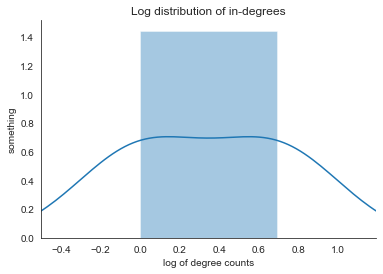

The average in-degree (including zeros): 1.5
The average in-degree (excluding zeros): 1.5


/vol/home/s1528459/anaconda3/envs/TM/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/vol/home/s1528459/anaconda3/envs/TM/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


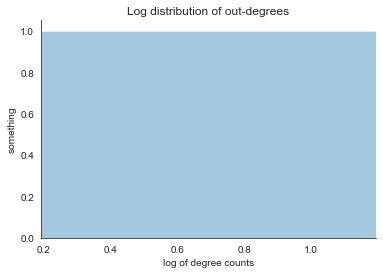

The average out-degree (including zeros): 1.5
The average out-degree (excluding zeros): 2.0
Implementing the transition matrix M in the traditional manner...
...and storing both M and the initial vector v in RAM requires 160.0 B of RAM
------------------
Implementing the transition matrix M using a sparse matrix...
...and storing both M and the initial vector v in RAM requires 53.333 B of RAM
------------------
Implementing the transition matrix M using the format specified on slide 17 of the instructions...
...and storing both M and the initial vector v in RAM requires 85.333 B of RAM


In [22]:
simple_data = load_prepped_data('simple_data.npz')
print(simple_data.todense())
analyze_dead_ends(simple_data)
analyze_in_degrees(simple_data)
analyze_out_degrees(simple_data)
analyze_ram_requirements(simple_data)